In [1]:
#import pkgs
import time
import networkx as nx
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import gc 
import sys
from scipy.stats import moment
from scipy.optimize import curve_fit

Fractal model

In [2]:
#inputs: N - the maximum number of nodes
#        m - mdeg(v) nodes get added to each node in the old graph 
#        e - probability of choosing an edge in the old graph vs an edge in the new graph
def fm(N, m, e):
    G = nx.Graph()
    G.add_edges_from([(0, i) for i in range(1, 5)]) #create a star graph
    while len(G.nodes) + 2*m*len(G.edges) < N:
        E_old = list(G.edges)
        index = len(G.nodes) #starting new node index 
        new_neighbors_dict = {} #track new neighbors for each v in old V
        for v in list(G.nodes).copy():
            edge_ct = m*len(list(G.neighbors(v)))
            new_neighbors_dict[v] = [i+index for i in range(edge_ct)]
            G.add_edges_from([(v, neighbor) for neighbor in new_neighbors_dict[v]])
            index += edge_ct
        for edge in E_old:
            if np.random.rand() < 1 - e: 
                G.remove_edge(*edge) #remove old edge
                #add new edge between nonhubs
                new_edge = (np.random.choice(new_neighbors_dict[edge[0]]),
                           np.random.choice(new_neighbors_dict[edge[1]]))
                G.add_edge(*new_edge)
    return G

Fractal model sanity checking

In [ ]:
fm1 = fm(1000, 2, 0.5)
nx.draw(fm1)

GCA 

In [3]:
#inputs: G - a graph
#        l_B - box size l_B
#output: newG - the transformed graph
def gca(G, l_B):
    #calculate distances between every vertex in G
    p = dict(nx.all_pairs_shortest_path_length(G, l_B))
    #add infs to p 
    for i in G.nodes:
        for j in set(G.nodes).difference(set(p[i].keys())):
            p[i][j] = np.inf
    #construct G' 
    Gp = nx.Graph()
    Gp.add_nodes_from(G.nodes)
    Gp.add_edges_from([(i, j) for i in G.nodes for j in p[i].keys() if p[i][j] >= l_B])
    c = nx.greedy_color(Gp)
    newG = nx.Graph()
    #add nodes 
    new_nodes = list(set(c.values()))
    newG.add_nodes_from(new_nodes)
    #add edges 
    #get inv_c, color:[nodes]
    inv_c = {i:[j for j in Gp.nodes if c[j] == i] for i in c.values()}
    del Gp 
    #construct neighbor dict for G
    G_neighbor_dict = {i:list(G.neighbors(i)) for i in G.nodes}
    #get inv_neigh, color:[neighbors of nodes with this color IN G NOT IN Gp]
    inv_neigh = {i: set([l 
                     for k in [list(G_neighbor_dict[j]) for j in inv_c[i]]
                         for l in k])
                     for i in c.values()}
    for i in new_nodes:
        #get nodes in 
        for j in set(new_nodes).difference(set([i])):
            for k in inv_c[i]:
                if k in inv_neigh[j]:
                    newG.add_edge(i, j)
                    break
    return newG

# calculate kappa 
def get_kappa(G):
    #find max degree 
    return max(dict(G.degree).values())/(len(G.nodes) - 1) 

#calculate x, the relative network size
def get_x(G, n_0):
    return len(G.nodes)/n_0
# calculate chi 
def get_chi(kappas):
    return (np.std(kappas))**2

# power-law fitting -> get from Ising lab 


In [ ]:
# Sanity checking GCA with a line graph
line = nx.Graph()
line.add_edges_from([[i, i+1] for i in range(20)])
line_test = gca(line, l_B)

#print(line_test.edges)
nx.draw(line_test)
#len(line_test.nodes)

In [205]:
# Sanity checking a single E-R graph
# Sanity checking the memory usage 
n_0 = 21 #num nodes 
avg_deg = 2
l_B = 3
p = avg_deg/n_0 
np.random.seed(0)

test = nx.erdos_renyi_graph(n_0, p) #graph generation
test = max(nx.connected_component_subgraphs(test), key=len)
#perform GCA repeatedly and store the kappas 
kappas = []
xs = []
graphs = []
while list(test.edges) != []:
    kappas.append(get_kappa(test))
    graphs.append(test)
    test = gca(test, l_B)
kappas.append(get_kappa(test))
graphs.append(test)

In [320]:
# Sanity checking a single fm graph
n_0 = 5000 #num nodes 

test = fm(n_0, 1, 0.5) #graph generation
#perform GCA repeatedly and store the kappas 
kappas = []
xs = []
graphs = []
while list(test.edges) != []:
    kappas.append(get_kappa(test))
    graphs.append(test)
    test = gca(test, l_B)

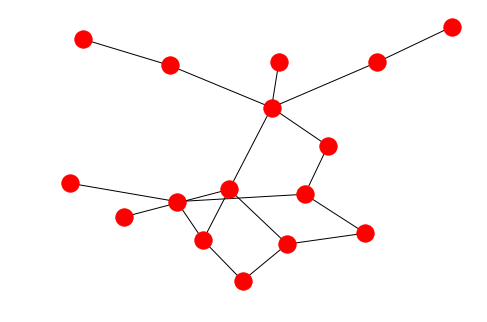

In [312]:
n_0 = 16

test = nx.erdos_renyi_graph(16, 2/16) #graph generation
nx.draw(test)

9


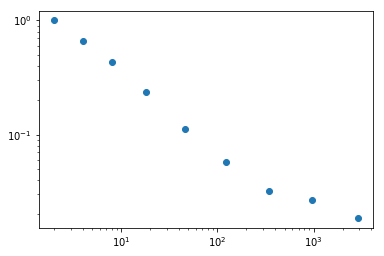

In [322]:
print(len(graphs))
plt.plot([len(graph.nodes) for graph in graphs], kappas, 'o')
plt.yscale('log')
plt.xscale('log')

(-1.136733475478566, 1.136733493359959, -1.1027219458758792, 1.102722058727865)

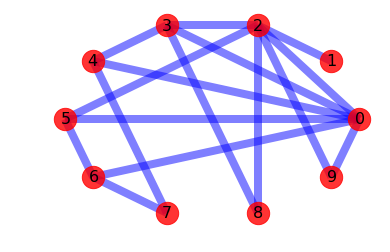

In [356]:
#draw G and Gp 
#test = nx.barabasi_albert_graph(8, 2)
#nx.draw(test)
pos=nx.circular_layout(test)
nx.draw_networkx_nodes(test, pos,
                       nodelist=test.nodes,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_edges(test,pos,
                       edgelist=test.edges,
                       width=8,alpha=0.5,edge_color='b')
nx.draw_networkx_labels(test,pos,labels,font_size=16)
plt.axis('off')

(-1.136733475478566, 1.136733493359959, -1.1027219458758792, 1.102722058727865)

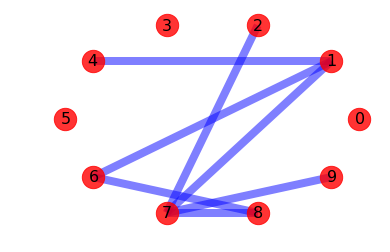

In [357]:
#draw G and Gp 
#test = nx.barabasi_albert_graph(10, 2)
G = test
#calculate distances between every vertex in G
p = dict(nx.all_pairs_shortest_path_length(G, l_B))
#add infs to p 
for i in G.nodes:
    for j in set(G.nodes).difference(set(p[i].keys())):
        p[i][j] = np.inf
#construct G' 
Gp = nx.Graph()
Gp.add_nodes_from(G.nodes)
Gp.add_edges_from([(i, j) for i in G.nodes for j in p[i].keys() if p[i][j] >= l_B])
#nx.draw(test)
pos=nx.circular_layout(Gp)
nx.draw_networkx_nodes(Gp, pos,
                       nodelist=Gp.nodes,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_edges(Gp,pos,
                       edgelist=Gp.edges,
                       width=8,alpha=0.5,edge_color='b')
labels={i: r'${}$'.format(i) for i in range(len(G.nodes))}
nx.draw_networkx_labels(Gp,pos,labels,font_size=16)
plt.axis('off')

In [346]:
Gp.edges

EdgeView([(0, 6), (1, 7), (5, 7)])

Generate multiple E-R graphs and get the mean kappa and chi

In [ ]:
num_graphs = 10
for n in [5000]: #took 17GB for one graph! TO DO 
    n_0 = n #number of nodes in starting graph
    avg_deg = 2 #average degree of a node in the graph 
    l_B = 3 #max distance between nodes in a box 
    p = avg_deg/n_0 #probability of generating an edge between two nodes 
    kappas_all = [] #list of kappas=[] for all graphs 
    xs_all = []
    t = time.time()
    for i in range(num_graphs):
        test = nx.erdos_renyi_graph(n_0, p) #graph generation
        #perform GCA repeatedly and store the kappas 
        kappas = []
        xs = []
        while list(test.edges) != []:
            kappas.append(get_kappa(test))
            xs.append(get_x(test, n_0))
            test = gca(test, l_B)
            gc.collect()
        kappas_all.append(kappas)
        xs_all.append(xs)
        print(i, time.time() - t)
        gc.collect()
    print(n, time.time() - t)
    #10 graphs took 882 seconds 
    #get_kappa(test)
    #pickle data 
    filename = 'er' + str(n_0)
    f = open(filename,'wb')
    for i in [kappas_all, xs_all]:
        pkl.dump(i,f)
    f.close()

In [ ]:
for i in range(len(xs_all)):
    plt.scatter(xs_all[i], kappas_all[i])
plt.yscale('log')
plt.xscale('log')

generate multiple B-A graphs 

In [ ]:
#B-A 
num_graphs = 10
for n in [1000, 2000, 5000, 10000]:
    n_0 = n #number of nodes in starting graph
    new_edges = 2 #number of edges to attach from a new node to existing nodes
    l_B = 3 #max distance between nodes in a box 
    kappas_all = [] #list of kappas=[] for all graphs 
    xs_all = []
    t = time.time()
    for i in range(num_graphs):
        test = nx.barabasi_albert_graph(n_0, new_edges, i) #graph generation
        #perform GCA repeatedly and store the kappas 
        kappas = []
        xs = []
        while list(test.edges) != []:
            kappas.append(get_kappa(test))
            xs.append(get_x(test, n_0))
            test = gca(test, l_B)
            gc.collect()
        kappas_all.append(kappas)
        xs_all.append(xs)
        print(i)
    print(time.time() - t)
    #10 graphs took 882 seconds 
    #get_kappa(test)
    #pickle data 
    filename = 'ba' + str(n_0)
    f = open(filename,'wb')
    for i in [kappas_all, xs_all]:
        pkl.dump(i,f)
    f.close()

In [ ]:
for i in range(len(xs_all)):
    plt.scatter(xs_all[i], kappas_all[i])
    
#plt.yscale('log')
#plt.xscale('log')

generate multiple fm graphs

In [ ]:
#fm
num_graphs = 10
for n in [5000]:
    n_0 = n #number of nodes in starting graph
    new_edges = 2 #number of edges to attach from a new node to existing nodes
    l_B = 3 #max distance between nodes in a box 
    kappas_all = [] #list of kappas=[] for all graphs 
    xs_all = []
    t = time.time()
    for i in range(num_graphs):
        test = fm(n_0, 2, 0.5) #graph generation
        #perform GCA repeatedly and store the kappas 
        kappas = []
        xs = []
        while list(test.edges) != []:
            kappas.append(get_kappa(test))
            xs.append(get_x(test, n_0))
            test = gca(test, l_B)
            gc.collect()
        kappas_all.append(kappas)
        xs_all.append(xs)
        print(i, time.time() - t)
    print(time.time() - t)
    #10 graphs took 882 seconds 
    #get_kappa(test)
    #pickle data 
    filename = 'fm' + str(n_0)
    f = open(filename,'wb')
    for i in [kappas_all, xs_all]:
        pkl.dump(i,f)
    f.close()

In [ ]:
print(kappas_all)
print(xs_all)

In [ ]:
#pickle data 
filename = 'fm' + str(n_0)
f = open(filename,'wb')
for i in [kappas_all, xs_all]:
    pkl.dump(i,f)
f.close()

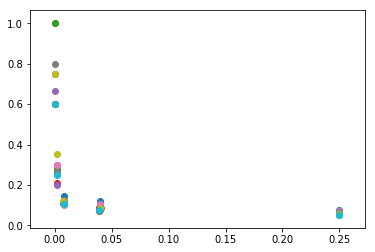

In [16]:
n_0 = 10000
filename = 'fm' + str(n_0)
with open(filename, "rb") as f:
    kappas_all = pkl.load(f)
    xs_all = pkl.load(f)
for i in range(len(xs_all)):
    plt.scatter(xs_all[i], kappas_all[i])

analysis

In [4]:
#for the same t, average the kappas and the xs together
kappas_all_dict = {i:{} for i in ['er', 'ba', 'fm']} #dict['graph type'][n_0] = array of data
kappas_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000] } 
                   for i in ['er', 'ba', 'fm']}
chis_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000] } #VARIANCE
                 for i in ['er', 'ba', 'fm']}
dchis_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000] }  #VARIANCE
                  for i in ['er', 'ba', 'fm']}
xs_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000]}
              for i in ['er', 'ba', 'fm']}
xs_all_dict = {i:{} for i in ['er', 'ba', 'fm']}
fdict = {'er':'_conn_', 
        'ba': '_sparse_new_',
        'fm':'_new1_'}
for i in ['er', 'ba', 'fm']:
    for n_0 in [1000, 2000, 5000, 10000, 20000]:
        filename = "workable_data/" + i + fdict[i] + str(n_0)
        with open(filename, "rb") as f:
            kappas_all = pkl.load(f)
            xs_all = pkl.load(f)
        kappas_all_dict[i][n_0] = kappas_all
        xs_all_dict[i][n_0] = xs_all
        max_t = np.max([len(ls) for ls in kappas_all])
        for idx in range(max_t):
            temp = [ls[idx] for ls in kappas_all if idx < len(ls)] #all the kappa_t
            xs_temp = [ls[idx] for ls in xs_all if idx < len(ls)]
            kappas_avg_dict[i][n_0].append(np.average(temp))
            chis_avg_dict[i][n_0].append(n_0*np.std(temp)**2)
            dchis_avg_dict[i][n_0].append(n_0**2*(moment(temp, 4) - moment(temp, 2)**2)/len(temp))
            xs_avg_dict[i][n_0].append(np.average(xs_temp))

In [7]:
#sanity check the monster u created
print("average kappas", kappas_avg_dict['fm'][10000])
print("chis", chis_avg_dict['fm'][10000])
print("dchis", dchis_avg_dict['fm'][10000])

average kappas [0.057328000000000004, 0.0648, 0.07027766599597586, 0.1457750759878419, 0.2503529411764706, 0.5480000000000002, 1.0]
chis [4.616601600000001e-05, 2.4960000000000042e-05, 0.00018690013724196285, 9.223861568167334e-06, 0.00024566551326412906, 0.0024959999999999987, 0.0]
dchis [2.732437222195074e-13, 7.987200000000649e-14, 4.4784181155208445e-12, 1.0907643875483546e-14, 7.737377488118832e-12, 7.987199999998893e-10, 0.0]


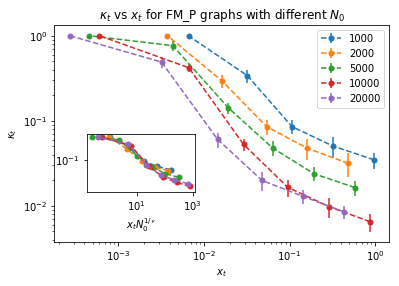

In [201]:
#kappa plots for various graphs, over all n_0


# These are in unitless percentages of the figure size. (0,0 is bottom left)

for i in ['fm_p']:# 'ba', 'fm']:
    fig, ax1 = plt.subplots()
    left, bottom, width, height = [0.2, 0.3, 0.25, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    for n_0 in [1000, 2000, 5000, 10000, 20000]:
        #plt.plot(xs_avg_dict[i][n_0], kappas_avg_dict[i][n_0], '--')
        ax1.errorbar(xs_avg_dict[i][n_0], kappas_avg_dict[i][n_0],
                     np.sqrt(1/n_0*np.array(chis_avg_dict[i][n_0])), marker='o',
                     ms = 5, linestyle='--')
        nu = 1.35
        x_ax = [x*(n_0)**(1/nu) for x in xs_avg_dict[i][n_0]]
        ax2.errorbar(x_ax, kappas_avg_dict[i][n_0],
                     np.sqrt(1/n_0*np.array(chis_avg_dict[i][n_0])), marker='o',
                     ms = 5, linestyle='--')
        title = "$\kappa_t$ vs $x_t$ for {} graphs with different $N_0$".format(i.upper())
        ax1.set_title(title)
        ax1.legend(labels = ['1000', '2000', '5000', '10000', '20000'])
        ax1.set_xlabel("$x_t$")
        ax1.set_ylabel("$\kappa_t$")
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        ax2.set_xlabel("$x_tN_0^{1/ \mathcal{v}}$")
        ax2.set_yscale('log')
        ax2.set_xscale('log')

    #plt.ylim((10**(-1), 10**(-3)))
    plt.savefig('pics/{}_kappa_upload.eps'.format(i.upper()), format='eps', dpi=1000)
    #plt.clf()

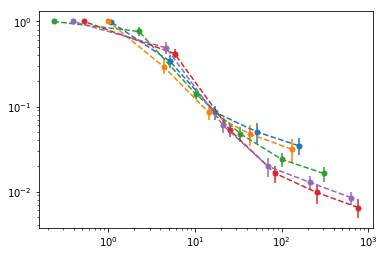

In [200]:
#inset only 

for i in ['fm_p']:# 'ba', 'fm']:
    for n_0 in [1000, 2000, 5000, 10000, 20000]:
        #plt.plot(xs_avg_dict[i][n_0], kappas_avg_dict[i][n_0], '--')
        nu = 1.3
        x_ax = [x*(n_0)**(1/nu) for x in xs_avg_dict[i][n_0]]
        plt.errorbar(x_ax, kappas_avg_dict[i][n_0],
                     np.sqrt(1/n_0*np.array(chis_avg_dict[i][n_0])), marker='o',
                     ms = 5, linestyle='--')
        plt.xscale("log")
        plt.yscale("log")

In [52]:
#scaling function... 

#plot k_t as a function of x_t, inputs = (x_t, n_0) vecs

def kappa_func(inputs, a, nu):
    x_t, n_0 = inputs
    return a*x_t*n_0**(1/nu)

i = 'er'
t = 1
#as a function of n_0!!! 
n_0s = [1000, 2000, 5000, 10000, 20000]
k_t = [kappas_avg_dict[i][n_0][t] for n_0 in n_0s]
k_tstdev = np.array([np.sqrt(chis_avg_dict[i][n_0][t]) for n_0 in n_0s])
x_t = [xs_avg_dict[i][n_0][t] for n_0 in n_0s]
params_kappa = curve_fit(kappa_func, (x_t, n_0s), 
                         k_t)# sigma=1/k_tstdev, absolute_sigma=True)

In [36]:
#plot fit results
params_kappa
#plt.scatter([480:], chi[480:])
#plt.errorbar(temp[480:], chi[480:], chi_stdev[480:], linestyle='None')

(array([2.93899641e-03, 9.65579087e+07]),
 array([[2.48349939e-04, 4.65098515e+13],
        [4.65098515e+13, 8.78915794e+30]]))

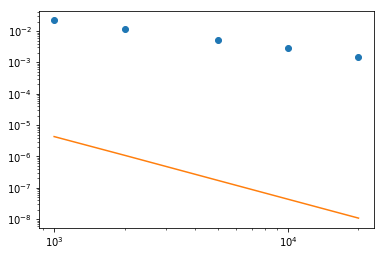

In [76]:
#plot k_t as a function of x_t*(N_0)**(1/nu)
nu = 2
plt.plot([n_0 for x, n_0 in zip(x_t, n_0s)], k_t, 'o')
plt.plot(n_0s, [x*10*n_0**(-2) for x, n_0 in zip(x_t, n_0s)],
         '-')
plt.yscale('log')
plt.xscale('log')

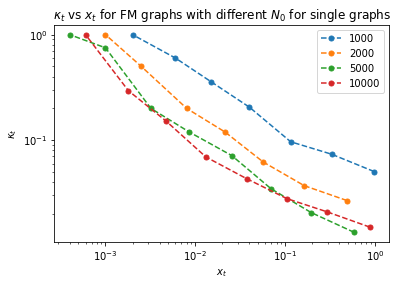

In [460]:
#if non-linearity is due to averaging
#plot individual kappas
#kappa plots for various graphs, over all n_0
for i in ['fm']:
    for n_0 in [1000, 2000, 5000, 10000]:# 20000]:
        #plt.plot(xs_avg_dict[i][n_0], kappas_avg_dict[i][n_0], '--')
        plt.errorbar(xs_all_dict[i][n_0][3], kappas_all_dict[i][n_0][3],
                    marker='o',
                     ms = 5, linestyle='--')
    plt.title("$\kappa_t$ vs $x_t$ for {} graphs with different $N_0$ for single graphs" .format(i.upper()))
    plt.legend(labels = ['1000', '2000', '5000', '10000', '20000'])
    plt.xlabel("$x_t$")
    plt.ylabel("$\kappa_t$")
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim((10**(-1), 10**(-3)))
    #plt.savefig('pics/{}_kappa_fm_singleg.eps'.format(i.upper()), format='eps', dpi=1000)
    #plt.clf()

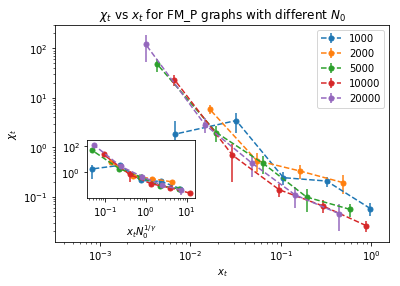

In [220]:
#chi plots for various graphs, over all n_0
for i in ['fm_p']:#, 'fm', 'ba']:
    fig, ax1 = plt.subplots()
    left, bottom, width, height = [0.2, 0.28, 0.25, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    for n_0 in [1000, 2000, 5000, 10000, 20000]:
        #don't plot zero-valued chis! 
        plot_chis = [chi for chi in chis_avg_dict[i][n_0] if chi != 0.0]
        plot_dchis = [dchi for dchi, chi 
                      in zip(dchis_avg_dict[i][n_0],chis_avg_dict[i][n_0])
                        if chi != 0.0]
        plot_xs = [xs for xs, chi 
                      in zip(xs_avg_dict[i][n_0],chis_avg_dict[i][n_0])
                        if chi != 0.0]
        ax1.errorbar(plot_xs, plot_chis,
                     np.sqrt(plot_dchis), marker='o',
                     ms = 5, linestyle='--')
        nu = 3.5
        x_ax = [x*(n_0)**(1/nu) for x in plot_xs]
        ax2.errorbar(x_ax, plot_chis,
                     np.sqrt(plot_dchis), marker='o',
                     ms = 5, linestyle='--')
        title = "$\chi_t$ vs $x_t$ for {} graphs with different $N_0$".format(i.upper())
        ax1.set_title(title)
        ax1.legend(labels = ['1000', '2000', '5000', '10000', '20000'])
        ax1.set_xlabel("$x_t$")
        ax1.set_ylabel("$\chi_t$")
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        ax2.set_xlabel("$x_tN_0^{1/ \gamma}$")
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        ax1.set_xlim((10**(-3.5), 10**(0.2)))
    plt.savefig('pics/{}_chi_upload.eps'.format(i.upper()), format='eps', dpi=1000)
    #plt.clf()

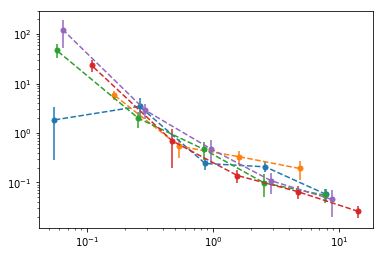

In [219]:
#inset only 

for i in ['fm_p']:# 'ba', 'fm']:
    for n_0 in [1000, 2000, 5000, 10000, 20000]:
        #plt.plot(xs_avg_dict[i][n_0], kappas_avg_dict[i][n_0], '--')
        plot_chis = [chi for chi in chis_avg_dict[i][n_0] if chi != 0.0]
        plot_dchis = [dchi for dchi, chi 
                      in zip(dchis_avg_dict[i][n_0],chis_avg_dict[i][n_0])
                        if chi != 0.0]
        plot_xs = [xs for xs, chi 
                      in zip(xs_avg_dict[i][n_0],chis_avg_dict[i][n_0])
                        if chi != 0.0]
        nu =3.3
        x_ax = [x*(n_0)**(1/nu) for x in plot_xs]
        plt.errorbar(x_ax, plot_chis,
                     np.sqrt(plot_dchis), marker='o',
                     ms = 5, linestyle='--')
        plt.xscale("log")
        plt.yscale("log")

perturbation 

In [34]:
#watts-strogatz, without perturbation (only 1 graph per section because it's predetermined)

num_graphs = 1
for n in [1000, 2000, 5000, 10000, 20000]:
    n_0 = n #number of nodes in starting graph
    k = 4 #number of nearest neighbors
    p = 0 #prob rewiring
    l_B = 3 #max distance **+ 1** between nodes in a box 
    kappas_all = [] #list of kappas=[] for all graphs 
    xs_all = []
    t = time.time()
    for i in range(num_graphs):
        test = nx.watts_strogatz_graph(n_0, k, p) #graph generation
        #perform GCA repeatedly and store the kappas 
        kappas = []
        xs = []
        while list(test.edges) != []:
            kappas.append(get_kappa(test))
            xs.append(get_x(test, n_0))
            test = gca(test, l_B)
            gc.collect()
        kappas_all.append(kappas)
        xs_all.append(xs)
        print(i, time.time() - t)
    print(time.time() - t)
    #10 graphs took 882 seconds 
    #get_kappa(test)
    #pickle data 
    filename = 'data/ws_no_perturb' + str(n_0)
    f = open(filename,'wb')
    for i in [kappas_all, xs_all]:
        pkl.dump(i,f)
    f.close()

0 6.655810832977295
6.656088829040527


In [35]:
#watts-strogatz, with perturbation 

num_graphs = 50
for n in [1000, 2000, 5000, 10000, 20000]:
    n_0 = n #number of nodes in starting graph
    k = 4 #number of nearest neighbors
    p = 0.01 #prob rewiring
    l_B = 3 #max distance **+ 1** between nodes in a box 
    kappas_all = [] #list of kappas=[] for all graphs 
    xs_all = []
    t = time.time()
    for i in range(num_graphs):
        test = nx.watts_strogatz_graph(n_0, k, p) #graph generation
        #perform GCA repeatedly and store the kappas 
        kappas = []
        xs = []
        while list(test.edges) != []:
            kappas.append(get_kappa(test))
            xs.append(get_x(test, n_0))
            test = gca(test, l_B)
            gc.collect()
        kappas_all.append(kappas)
        xs_all.append(xs)
        print(i, time.time() - t)
    print(time.time() - t)
    #10 graphs took 882 seconds 
    #get_kappa(test)
    #pickle data 
    filename = 'data/ws_perturb' + str(n_0)
    f = open(filename,'wb')
    for i in [kappas_all, xs_all]:
        pkl.dump(i,f)
    f.close()

[[0.004004004004004004,
  0.010050251256281407,
  0.030303030303030304,
  0.09090909090909091,
  0.2857142857142857,
  1.0]]

ws analysis

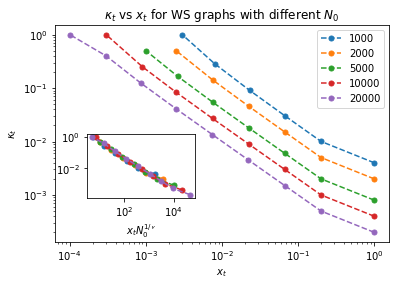

In [130]:
#plot non-perturbed WS
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.2, 0.28, 0.25, 0.22]
ax2 = fig.add_axes([left, bottom, width, height])
for n_0 in [1000, 2000, 5000, 10000, 20000]:
    filename = "workable_data/ws_no_perturb" + str(n_0)
    with open(filename, "rb") as f:
        kappas_all = pkl.load(f)[0]
        xs_all = pkl.load(f)[0]
        ax1.plot(xs_all, kappas_all, marker='o',
                     ms = 5, linestyle='--')
        nu = 0.92
        x_ax = [x*(n_0)**(1/nu) for x in xs_all]
        ax2.plot(x_ax, kappas_all, marker='o',
                     ms = 5, linestyle='--')
        title = "$\kappa_t$ vs $x_t$ for {} graphs with different $N_0$".format("WS")
        ax1.set_title(title)
        ax1.legend(labels = ['1000', '2000', '5000', '10000', '20000'])
        ax1.set_xlabel("$x_t$")
        ax1.set_ylabel("$\kappa_t$")
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        ax2.set_xlabel("$x_tN_0^{1/ \mathcal{v}}$")
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        #ax1.set_xlim((10**(-4.5), 10**(0.2)))
    #plt.savefig('pics/{}_ws_noperturb.eps'.format(i.upper()), format='eps', dpi=1000)
    

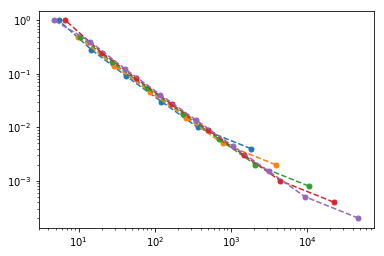

In [128]:
#plot non-perturbed WS inset
for n_0 in [1000, 2000, 5000, 10000, 20000]:
    filename = "workable_data/ws_no_perturb" + str(n_0)
    with open(filename, "rb") as f:
        kappas_all = pkl.load(f)[0]
        xs_all = pkl.load(f)[0]
        nu = 0.92
        x_ax = [x*(n_0)**(1/nu) for x in xs_all]
        plt.plot(x_ax, kappas_all, marker='o',
                     ms = 5, linestyle='--')
        plt.yscale('log')
        plt.xscale('log')
        #ax1.set_xlim((10**(-4.5), 10**(0.2)))
    #plt.savefig('pics/{}_ws_noperturb.eps'.format(i.upper()), format='eps', dpi=1000)
    


In [131]:
#perturbed version for BA, FM, WS

#for the same t, average the kappas and the xs together
kappas_all_dict = {i:{} for i in ['ba_p', 'fm_p', 'ws_p']} #dict['graph type'][n_0] = array of data
kappas_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000] } 
                   for i in ['ba_p', 'fm_p', 'ws_p']}
chis_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000] } #VARIANCE
                 for i in ['ba_p', 'fm_p', 'ws_p']}
dchis_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000] }  #VARIANCE
                  for i in ['ba_p', 'fm_p', 'ws_p']}
xs_avg_dict = {i:{n:[] for n in [1000, 2000, 5000, 10000, 20000]}
              for i in ['ba_p', 'fm_p', 'ws_p']}
xs_all_dict = {i:{} for i in ['ba_p', 'fm_p', 'ws_p']}
for i in ['ba_p', 'fm_p', 'ws_p']:
    for n_0 in [1000, 2000, 5000, 10000, 20000]:
        filename = "workable_data/" + i + "erturb" + str(n_0)
        with open(filename, "rb") as f:
            kappas_all = pkl.load(f)
            xs_all = pkl.load(f)
        kappas_all_dict[i][n_0] = kappas_all
        xs_all_dict[i][n_0] = xs_all
        max_t = np.max([len(ls) for ls in kappas_all])
        for idx in range(max_t):
            temp = [ls[idx] for ls in kappas_all if idx < len(ls)] #all the kappa_t
            xs_temp = [ls[idx] for ls in xs_all if idx < len(ls)]
            kappas_avg_dict[i][n_0].append(np.average(temp))
            chis_avg_dict[i][n_0].append(n_0*np.std(temp)**2)
            dchis_avg_dict[i][n_0].append(n_0**2*(moment(temp, 4) - moment(temp, 2)**2)/len(temp))
            xs_avg_dict[i][n_0].append(np.average(xs_temp))

real world networks!

In [132]:
#Load collaboration networks
exts = ['AstroPh', 'GrQc', 'HepPh', 'HepTh']
collab_gs = {}
for i in exts:
    f = open("real_world/ca-{}.txt".format(i), "r")
    raw_hep = []
    for line in f:
        raw_hep.append(line.strip().split("\t"))
    f.close()
    raw_hep = raw_hep[4:]
    G_hep = nx.Graph()
    G_hep.add_edges_from(raw_hep)
    #map nodes of G_hep to nodes numbering from 0 to 9877
    node_order = np.random.permutation(G_hep.nodes)
    order_dict = {i:j for i, j in zip(G_hep.nodes, node_order)}
    G_hep = nx.relabel_nodes(G_hep, order_dict)
    G_hep = max(nx.connected_component_subgraphs(G_hep), key=len)
    collab_gs[i] = G_hep

In [137]:
#sanity check graphs
print(collab_gs.keys())
for G in collab_gs.values():
    print(len(G.nodes), len(G.edges))

dict_keys(['AstroPh', 'GrQc', 'HepPh', 'HepTh'])
17903 197031
4158 13428
11204 117649
8638 24827


In [ ]:
#GCA on collab networks 

for i in exts:
    l_B = 3 #max distance **+ 1** between nodes in a box 
    kappas_all = [] #list of kappas=[] for all graphs 
    xs_all = []
    t = time.time()
    #perform GCA repeatedly and store the kappas 
    kappas = []
    xs = []
    test = collab_gs[i]
    n_0 = len(test.nodes)
    while list(test.edges) != []:
        kappas.append(get_kappa(test))
        xs.append(get_x(test, n_0))
        test = gca(test, l_B)
        gc.collect()
    kappas_all.append(kappas)
    xs_all.append(xs)
    print(i, time.time() - t)
    print(time.time() - t)
    #pickle data 
    filename = 'data/collab_' + i
    f = open(filename,'wb')
    for i in [kappas_all, xs_all]:
        pkl.dump(i,f)
    f.close()

In [134]:
#Load airport networks
exts = ['USairport500', 'USairport_2010', 'openflights']
airport_gs = {}
for i in exts:
    f = open("real_world/{}.txt".format(i), "r")
    raw_hep = []
    for line in f:
        raw_hep.append(line.strip().split(" "))
    f.close()
    raw_hep = [i[:2] for i in raw_hep[4:]]
    G_hep = nx.Graph()
    G_hep.add_edges_from(raw_hep)
    #map nodes of G_hep to nodes numbering from 0 to 9877
    node_order = np.random.permutation(G_hep.nodes)
    order_dict = {i:j for i, j in zip(G_hep.nodes, node_order)}
    G_hep = nx.relabel_nodes(G_hep, order_dict)
    airport_gs[i] = G_hep

In [136]:
#sanity check the airport networks
print(airport_gs.keys()) #they're printed in alphabetical order
for G in airport_gs.values():
    print(len(G.nodes), len(G.edges))

dict_keys(['openflights', 'USairport500', 'USairport_2010'])
2939 15677
500 2980
1574 17215


In [ ]:
#GCA on airport networks 

for i in exts:
    l_B = 3 #max distance **+ 1** between nodes in a box 
    kappas_all = [] #list of kappas=[] for all graphs 
    xs_all = []
    t = time.time()
    #perform GCA repeatedly and store the kappas 
    kappas = []
    xs = []
    test = airport_gs[i]
    n_0 = len(test.nodes)
    while list(test.edges) != []:
        kappas.append(get_kappa(test))
        xs.append(get_x(test, n_0))
        test = gca(test, l_B)
        gc.collect()
    kappas_all.append(kappas)
    xs_all.append(xs)
    print(i, time.time() - t)
    print(time.time() - t)
    #pickle data 
    filename = 'data/airport_' + i
    f = open(filename,'wb')
    for i in [kappas_all, xs_all]:
        pkl.dump(i,f)
    f.close()

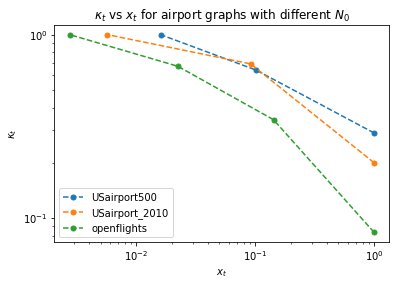

In [131]:
#load airport results 
exts = ['USairport500', 'USairport_2010', 'openflights']
#plot non-perturbed WS
fig, ax1 = plt.subplots()
for i in exts:
    filename = "workable_data/airport_" + i
    with open(filename, "rb") as f:
        kappas_all = pkl.load(f)[0]
        xs_all = pkl.load(f)[0]
        ax1.plot(xs_all, kappas_all, marker='o',
                     ms = 5, linestyle='--')
        title = "$\kappa_t$ vs $x_t$ for {} graphs with different $N_0$".format("airport")
        ax1.set_title(title)
        ax1.legend(labels = exts)
        ax1.set_xlabel("$x_t$")
        ax1.set_ylabel("$\kappa_t$")
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        #ax1.set_xlim((10**(-4.5), 10**(0.2)))
    plt.savefig('pics/{}_upload.eps'.format("airport"), format='eps', dpi=1000)
    

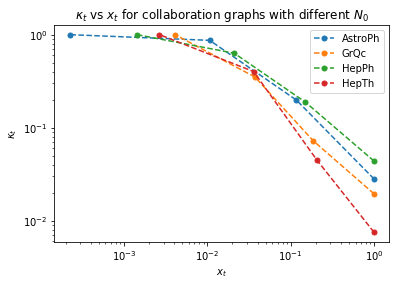

In [129]:
#load collab results 
exts = ['AstroPh', 'GrQc', 'HepPh', 'HepTh']
#plot non-perturbed WS
fig, ax1 = plt.subplots()
for i in exts:
    filename = "workable_data/collab_" + i
    with open(filename, "rb") as f:
        kappas_all = pkl.load(f)[0]
        xs_all = pkl.load(f)[0]
        ax1.plot(xs_all, kappas_all, marker='o',
                     ms = 5, linestyle='--')
        title = "$\kappa_t$ vs $x_t$ for {} graphs with different $N_0$".format("collaboration")
        ax1.set_title(title)
        ax1.legend(labels = exts)
        ax1.set_xlabel("$x_t$")
        ax1.set_ylabel("$\kappa_t$")
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        #ax1.set_xlim((10**(-4.5), 10**(0.2)))
    #plt.savefig('pics/{}_upload.eps'.format("collab"), format='eps', dpi=1000)

# To Do :

- Write GCA - done
- Debug GCA - done 11/27
- Verify GCA for one E-R graph - done 11/27 (passes multiple round)
- Collect statistics for multiple graphs to get $\kappa_t$ and $\chi_t$, and fit for power law 
- Do for multiple types of theoretical graphs (B-A, W-S, and fractal)
- Verify perturbations indicate unstable fixed point 
- Do for actual data

# Issues :

- Verify kappa = max deg / (N_t + 1 ) or minus one? Minus one - done
- Determine conditions under which G' is disconnected
- MEMORY ISSUES

# Metrics :
- Switching to built-in alg cut time from 77 to 71s for 10 ER graphs, n_0=1000

In [ ]:
np.inf > 3